# Final Project Code
#### Names: Kristy Bell (kab7kr), Yayi Feng (yf7qq), MacKenzye Leroy (zuf9mc)
#### Topic: Loan Default - Lending Club

---

**Research Question:**
For our final project, we aim to investigate different attributes that may contribute to loan default and determine the most effective attributes in predicting loan default.

**Data Source:**
We found a dataset through Kaggle which comes from the world’s largest peer-to-peer lending platform, Lending Club. The data set consists of 153 attributes describing loan status of 2,925,494 loans (1.8 GB) from 2007-2020.  

---



### Imports

In [1]:
import os
from pyspark.sql import SparkSession


from pyspark.sql import functions as F
from pyspark.sql.functions import col, asc,when

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml import Pipeline  
from pyspark.ml.feature import * 
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import IntegerType,BooleanType, FloatType, StringType

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [2]:
from pyspark import SparkContext

#Set up Spark Sessioon
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Final Project") \
    .config("spark.executor.memory", '30g') \
    .config('spark.executor.cores', '4') \
    .config('spark.executor.instances', '16') \
    .config("spark.driver.memory",'5g') \
    .getOrCreate()
sc = spark.sparkContext


In [3]:
#change Working Directory
cwd = os.getcwd()
path = "/project/ds5559/group3loan"

In [4]:
# Read data in csv format
df = spark.read.csv(f'{path}/Loan_status_2007_2020Q3.gzip',header=True,inferSchema=True)
df.count()

2925493

### EDA/Feature Selection
As a company distributing loans and collecting loan payments, it is critical for LendingClub to know how much liquid cash they have available.  The more loans they can distibute, the higher profit they will make through interest rates (or taking a cut of what people are lending each other). Furthermore, it is important that LendingClub is able to accurately disclose the risk associated with a loan so that they are fully transparent with their investors. To dive into this problem, we will construct several classification models where we are going to try to predict the "loan status" outcome variable. 

+---------------------------------------------------+-------+----+
|loan_status                                        |count  |prop|
+---------------------------------------------------+-------+----+
|Fully Paid                                         |1497783|0.51|
|Default                                            |433    |0.0 |
|In Grace Period                                    |10028  |0.0 |
|Does not meet the credit policy. Status:Fully Paid |1988   |0.0 |
|Charged Off                                        |362547 |0.12|
|Oct-2015                                           |1      |0.0 |
|Late (31-120 days)                                 |16154  |0.01|
|Issued                                             |2062   |0.0 |
|Current                                            |1031016|0.35|
|Does not meet the credit policy. Status:Charged Off|761    |0.0 |
|Late (16-30 days)                                  |2719   |0.0 |
+---------------------------------------------------+-------+-

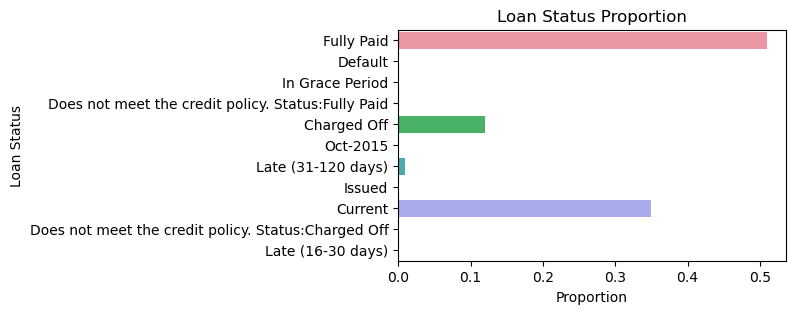

In [5]:
df = df.filter((col("loan_status")!="null")) # filter out value labeled as "null"
tot = df.count()
outcome_stats = df.groupBy("loan_status").count().\
        withColumn('prop', F.round((F.col('count') / tot),2))
outcome_stats.show(truncate=False)


outcome_stats = outcome_stats.toPandas()
plt.figure(figsize=(5,3))
sns.barplot(y='loan_status',x='prop',data=outcome_stats)
plt.ylabel('Loan Status')
plt.xlabel('Proportion')
plt.title('Loan Status Proportion')
plt.show()

Each loan status [explained](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-):  
- Fully paid: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment. (good)
- Default: Loan has not been current for an extended period of time. Learn more about the difference between “default” and “charge off”. (bad - down money)
- In Grace Period: Loan is past due but within the 15-day grace period. (fine - maybe risky)
- Charged Off: Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. Learn more about the difference between “default” and “charge off”. (bad - down money)
- Late (16-30): Loan has not been current for 16 to 30 days. Learn more about the tools LendingClub has to deal with delinquent borrowers. (bad - down money)
- Issued: New loan that has passed all LendingClub reviews, received full funding, and has been issued. (fine - might want to filter out)
- Current: Loan is up to date on all outstanding payments. (good)
- Late (31-120): Loan has not been current for 31 to 120 days. Learn more about the tools LendingClub has to deal with delinquent borrowers. (bad - down money)

We are going to wrangle this column to create a binary outcome: 
- {1: LendingClub is out money}  
- {0: if the loan is current/paid}  

We decided to filter out "Issued" loans and "In Grace Period" as those are someone neutral outcomes (neither paid nor late).

In [6]:
df = df.filter((col("loan_status")!="Issued")) # issued means no payment yet
df = df.filter((col("loan_status")!="In Grace Period")) # in grace period means only 0 to 15 days

outcome_column = when((df.loan_status == "Default")|\
                      (df.loan_status == "Charged Off")|\
                      (df.loan_status == "Late (31-120 days)")|\
                      (df.loan_status == "Does not meet the credit policy. Status:Charged Off")|\
                      (df.loan_status ==  "Late (16-30 days)"), 1).otherwise(0)

df = df.withColumn("lose_money", outcome_column)
df.groupBy("lose_money").count().\
        withColumn('prop', F.round((F.col('count') / tot),2)).show(truncate=False)

+----------+-------+----+
|lose_money|count  |prop|
+----------+-------+----+
|1         |382614 |0.13|
|0         |2530788|0.87|
+----------+-------+----+



As expected, we have a data imbalance where the target class (default) appears only in 13% of observations. 

**Feature selecting, filtering, engineering**

In [7]:
# ---- Feature engineering: ------ #

# make new dti variable that combines individual dti as well as joint dti
df = df.withColumn('DTI', when(df.dti.isNull(), df.dti_joint).otherwise(df.dti))
# filter out strange (non numerical entries)
df = df.filter(df.DTI != 'WI')
df = df.filter(df.DTI != 'SC')

# similarly, make a new variable for annual income that combines
df = df.withColumn('ANNUAL_INC', when(df.annual_inc.isNull(), df.annual_inc_joint).otherwise(df.annual_inc))
df = df.filter(df.ANNUAL_INC != 'MORTGAGE') # filter out weird mortgage value



outcome_var = ["lose_money"]

categorical_vars = ["purpose", "term", "sub_grade","emp_length", \
                    "home_ownership","verification_status"]

numerical_vars = ["loan_amnt","DTI","last_fico_range_high", \
                  "total_pymnt","funded_amnt","funded_amnt_inv", \
                   "ANNUAL_INC","revol_bal"]

df = df.select(outcome_var+numerical_vars+categorical_vars)
df.show(2)

+----------+---------+-----+--------------------+---------------+-----------+---------------+----------+---------+-----------+----------+---------+----------+--------------+-------------------+
|lose_money|loan_amnt|  DTI|last_fico_range_high|    total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal|    purpose|      term|sub_grade|emp_length|home_ownership|verification_status|
+----------+---------+-----+--------------------+---------------+-----------+---------------+----------+---------+-----------+----------+---------+----------+--------------+-------------------+
|         0|     5000|27.65|                 704|5863.1551866952|       5000|         4975.0|     24000|    13648|credit_card| 36 months|       B2| 10+ years|          RENT|           Verified|
|         1|     2500|    1|                 499|        1014.53|       2500|         2500.0|     30000|     1687|        car| 60 months|       C4|  < 1 year|          RENT|    Source Verified|
+----------+---------+-----+--

In [8]:
df.count()

2913396

**Casting all features to the correct data type**

In [9]:
for var in categorical_vars:
    df = df.withColumn(var,df[var].cast(StringType()))
for var in numerical_vars:
    df = df.withColumn(var,df[var].cast(FloatType()))

In [10]:
df.dtypes

[('lose_money', 'int'),
 ('loan_amnt', 'float'),
 ('DTI', 'float'),
 ('last_fico_range_high', 'float'),
 ('total_pymnt', 'float'),
 ('funded_amnt', 'float'),
 ('funded_amnt_inv', 'float'),
 ('ANNUAL_INC', 'float'),
 ('revol_bal', 'float'),
 ('purpose', 'string'),
 ('term', 'string'),
 ('sub_grade', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('verification_status', 'string')]

In [11]:
#Checking for nulls
list=["purpose", "term", "sub_grade","emp_length","home_ownership","verification_status","loan_amnt","DTI","last_fico_range_high", "total_pymnt","funded_amnt","funded_amnt_inv", "ANNUAL_INC","revol_bal"]
for i in list: 
    df.filter(col(i).isNull()).show() 

+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+-------+----+---------+----------+--------------+-------------------+
|lose_money|loan_amnt|DTI|last_fico_range_high|total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal|purpose|term|sub_grade|emp_length|home_ownership|verification_status|
+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+-------+----+---------+----------+--------------+-------------------+
+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+-------+----+---------+----------+--------------+-------------------+

+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+-------+----+---------+----------+--------------+-------------------+
|lose_money|loan_amnt|DTI|last_fico_range_high|total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal|p

Removed emp_length for null values

**Split the data**

In [12]:
import random
random.seed(314)
training, test = df.randomSplit([0.7, 0.3])

In [13]:
# one hot encode the categorical variables
stringIndexer_purpose = StringIndexer(inputCol="purpose", outputCol="purpose_index")
mod = stringIndexer_purpose.fit(training)
indexed = mod.transform(training)

stringIndexer_term = StringIndexer(inputCol="term", outputCol="term_index")
mod = stringIndexer_term.fit(indexed)
indexed = mod.transform(indexed)

stringIndexer_sub_grade = StringIndexer(inputCol="sub_grade", outputCol="sub_grade_index")
mod = stringIndexer_sub_grade.fit(indexed)
indexed = mod.transform(indexed)

stringIndexer_home_ownership = StringIndexer(inputCol="home_ownership", outputCol="home_ownership_index")
mod = stringIndexer_home_ownership.fit(indexed)
indexed = mod.transform(indexed)

stringIndexer_verification_status = StringIndexer(inputCol="verification_status", outputCol="verification_status_index")
mod = stringIndexer_verification_status.fit(indexed)
indexed = mod.transform(indexed)

In [14]:
encoder = OneHotEncoder(inputCols=["purpose_index","term_index",
                                           "sub_grade_index",
                                          "home_ownership_index","verification_status_index"], 
                                outputCols=["purpose_ohe","term_ohe",
                                            "sub_grade_ohe",
                                           "home_ohe","verif_ohe"])
model = encoder.fit(indexed)
encoded = model.transform(indexed)

In [15]:
encoded.show(2)

+----------+---------+----+--------------------+-----------+-----------+---------------+----------+---------+-----------+----------+---------+----------+--------------+-------------------+-------------+----------+---------------+--------------------+-------------------------+---------------+-------------+--------------+-------------+-------------+
|lose_money|loan_amnt| DTI|last_fico_range_high|total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal|    purpose|      term|sub_grade|emp_length|home_ownership|verification_status|purpose_index|term_index|sub_grade_index|home_ownership_index|verification_status_index|  sub_grade_ohe|    verif_ohe|   purpose_ohe|     term_ohe|     home_ohe|
+----------+---------+----+--------------------+-----------+-----------+---------------+----------+---------+-----------+----------+---------+----------+--------------+-------------------+-------------+----------+---------------+--------------------+-------------------------+---------------+--------

In [16]:
encoded.dtypes

[('lose_money', 'int'),
 ('loan_amnt', 'float'),
 ('DTI', 'float'),
 ('last_fico_range_high', 'float'),
 ('total_pymnt', 'float'),
 ('funded_amnt', 'float'),
 ('funded_amnt_inv', 'float'),
 ('ANNUAL_INC', 'float'),
 ('revol_bal', 'float'),
 ('purpose', 'string'),
 ('term', 'string'),
 ('sub_grade', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('verification_status', 'string'),
 ('purpose_index', 'double'),
 ('term_index', 'double'),
 ('sub_grade_index', 'double'),
 ('home_ownership_index', 'double'),
 ('verification_status_index', 'double'),
 ('sub_grade_ohe', 'vector'),
 ('verif_ohe', 'vector'),
 ('purpose_ohe', 'vector'),
 ('term_ohe', 'vector'),
 ('home_ohe', 'vector')]

In [17]:
res = encoded.drop('purpose','term','sub_grade','emp_length','home_ownership','verification_status',\
            'purpose_index','term_index','sub_grade_index','home_ownership_index','verification_status_index',)

In [18]:
res.dtypes

[('lose_money', 'int'),
 ('loan_amnt', 'float'),
 ('DTI', 'float'),
 ('last_fico_range_high', 'float'),
 ('total_pymnt', 'float'),
 ('funded_amnt', 'float'),
 ('funded_amnt_inv', 'float'),
 ('ANNUAL_INC', 'float'),
 ('revol_bal', 'float'),
 ('sub_grade_ohe', 'vector'),
 ('verif_ohe', 'vector'),
 ('purpose_ohe', 'vector'),
 ('term_ohe', 'vector'),
 ('home_ohe', 'vector')]

In [19]:
res.show(2)

+----------+---------+----+--------------------+-----------+-----------+---------------+----------+---------+---------------+-------------+--------------+-------------+-------------+
|lose_money|loan_amnt| DTI|last_fico_range_high|total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal|  sub_grade_ohe|    verif_ohe|   purpose_ohe|     term_ohe|     home_ohe|
+----------+---------+----+--------------------+-----------+-----------+---------------+----------+---------+---------------+-------------+--------------+-------------+-------------+
|         0|    500.0| 0.0|               689.0|   541.2802|      500.0|          500.0|    3300.0|      0.0|(34,[14],[1.0])|(2,[1],[1.0])|    (13,[],[])|(1,[0],[1.0])|(5,[1],[1.0])|
|         0|    500.0|3.04|               499.0|  580.46277|      500.0|          500.0|   7904.04|     44.0| (34,[1],[1.0])|(2,[1],[1.0])|(13,[8],[1.0])|(1,[0],[1.0])|(5,[0],[1.0])|
+----------+---------+----+--------------------+-----------+-----------+-------------

In [20]:
assembler = VectorAssembler(inputCols=["purpose_ohe","term_ohe",\
                               "sub_grade_ohe", \
                               "home_ohe","verif_ohe", \
                                       "loan_amnt","DTI","last_fico_range_high", \
                  "total_pymnt","funded_amnt","funded_amnt_inv", \
                   "ANNUAL_INC","revol_bal"
                                ], outputCol="feature_vector")  
vec = assembler.transform(res)

In [21]:
vec.show(1)

+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+---------------+-------------+-----------+-------------+-------------+--------------------+
|lose_money|loan_amnt|DTI|last_fico_range_high|total_pymnt|funded_amnt|funded_amnt_inv|ANNUAL_INC|revol_bal|  sub_grade_ohe|    verif_ohe|purpose_ohe|     term_ohe|     home_ohe|      feature_vector|
+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+---------------+-------------+-----------+-------------+-------------+--------------------+
|         0|    500.0|0.0|               689.0|   541.2802|      500.0|          500.0|    3300.0|      0.0|(34,[14],[1.0])|(2,[1],[1.0])| (13,[],[])|(1,[0],[1.0])|(5,[1],[1.0])|(63,[13,28,49,54,...|
+----------+---------+---+--------------------+-----------+-----------+---------------+----------+---------+---------------+-------------+-----------+-------------+-------------+--------------------+


In [23]:
va = VectorAssembler(inputCols=["purpose_ohe","term_ohe",\
                               "sub_grade_ohe", "emp_ohe",\
                               "home_ohe","verif_ohe",
                                "loan_amnt","DTI","last_fico_range_high", \
                  "total_pymnt","funded_amnt","funded_amnt_inv", \
                   "ANNUAL_INC","revol_bal"], outputCol="feature_vector")  

scalar = MinMaxScaler(inputCol="feature_vector",outputCol="features")

#First model will be logistic regression
lr = LogisticRegression(labelCol='lose_money', featuresCol='features', maxIter=10, regParam=0.01)

## Model 1: Logistic Regression

**Build Pipeline for Logistic Regression**

In [24]:
# one hot encode the categorical variables
stringIndexer_purpose = StringIndexer(inputCol="purpose", outputCol="purpose_index")
stringIndexer_term = StringIndexer(inputCol="term", outputCol="term_index")
stringIndexer_sub_grade = StringIndexer(inputCol="sub_grade", outputCol="sub_grade_index")

stringIndexer_home_ownership = StringIndexer(inputCol="home_ownership", outputCol="home_ownership_index")
stringIndexer_verification_status = StringIndexer(inputCol="verification_status", outputCol="verification_status_index")

encoder_purpose = OneHotEncoder(inputCol="purpose_index", outputCol="purpose_ohe")
encoder_term = OneHotEncoder(inputCol="term_index", outputCol="term_ohe")
encoder_sub = OneHotEncoder(inputCol="sub_grade_index", outputCol="sub_grade_ohe")
encoder_home = OneHotEncoder(inputCol="home_ownership_index", outputCol="home_ohe")
encoder_verif = OneHotEncoder(inputCol="verification_status_index", outputCol="verif_ohe")

va = VectorAssembler(inputCols=["purpose_ohe","term_ohe",\
                               "sub_grade_ohe", \
                               "home_ohe","verif_ohe",
                                "loan_amnt","DTI","last_fico_range_high", \
                  "total_pymnt","funded_amnt","funded_amnt_inv", \
                   "ANNUAL_INC","revol_bal"], outputCol="feature_vector")  

scalar = MinMaxScaler(inputCol="feature_vector",outputCol="features")
lr = LogisticRegression(labelCol='lose_money', featuresCol='features', maxIter=10, regParam=0.01)

In [25]:
# Fit the pipeline
pipeline = Pipeline(stages=[stringIndexer_purpose,\
                            stringIndexer_term,\
                            stringIndexer_sub_grade,\
                            stringIndexer_home_ownership,\
                            stringIndexer_verification_status,\
                            encoder_purpose,\
                            encoder_term,\
                            encoder_sub,\
                            encoder_home,\
                            encoder_verif,\
                            va, scalar, lr]) 

In [121]:
model = pipeline.fit(training)

**Make predictions on the test set**

In [122]:
prediction = model.transform(test)
prediction.select('lose_money', 'probability','prediction').show(10, False)

+----------+------------------------------------------+----------+
|lose_money|probability                               |prediction|
+----------+------------------------------------------+----------+
|0         |[0.9288731204514541,0.07112687954854591]  |0.0       |
|0         |[0.9810956654196186,0.018904334580381432] |0.0       |
|0         |[0.6935004004072182,0.30649959959278184]  |0.0       |
|0         |[0.8960236058429614,0.10397639415703863]  |0.0       |
|0         |[0.951297356716972,0.04870264328302798]   |0.0       |
|0         |[0.9953291481931232,0.0046708518068767635]|0.0       |
|0         |[0.9844624124946857,0.01553758750531431]  |0.0       |
|0         |[0.9884014566207684,0.011598543379231607] |0.0       |
|0         |[0.9880288893546036,0.011971110645396354] |0.0       |
|0         |[0.9949960146995593,0.005003985300440661] |0.0       |
+----------+------------------------------------------+----------+
only showing top 10 rows



In [123]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [124]:
evaluator = BinaryClassificationEvaluator(labelCol='lose_money')

In [125]:
accuracy = evaluator.evaluate(prediction)
print('AUROC = ', accuracy)

AUROC =  0.9018310602907716


**Plotting ROC Curve**

In [126]:
PredAndLabels           = prediction.select("probability", "lose_money")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)



In [127]:
# Visualization
lr_FPR = dict()                                                        # FPR: False Positive Rate
lr_tpr = dict()                                                        # TPR: True Positive Rate
lr_roc_auc = dict()
 
lr_y_test = [i[1] for i in PredAndLabels_list]
lr_y_score = [i[0] for i in PredAndLabels_list]
 
lr_fpr, lr_tpr, _ = roc_curve(lr_y_test, lr_y_score)
lr_roc_auc = auc(lr_fpr, lr_tpr)

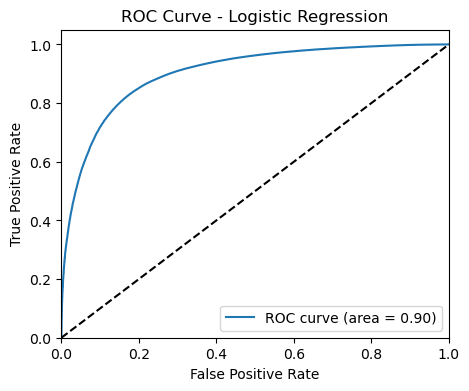

In [128]:
plt.figure(figsize=(5,4))
plt.plot(lr_fpr, lr_tpr, label='ROC curve (area = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


**Confusion Matrix**

In [41]:
cm_lr_result = prediction.crosstab("prediction", "lose_money")
cm_lr_result = cm_lr_result.toPandas()
cm_lr_result

,prediction_lose_money,0,1
0,1.0,7690,28794
1,0.0,751700,86254


**Other Metrics**

In [42]:
TP = cm_lr_result["1"][0]
FP = cm_lr_result["0"][0]
TN = cm_lr_result["0"][1]
FN = cm_lr_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.89
Sensitivity = 0.25
Specificity = 0.99
Precision = 0.79


### Hyperparamter Tuning

#### 5 iterations first (for time/memory constraints)

In [27]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [45]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [5]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0, .33, .67, 1]) \
    .build()

In [46]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='lose_money'),
                          numFolds=3)

In [47]:
cvModel = crossval.setParallelism(4).fit(training)

In [48]:
prediction = cvModel.transform(test)
prediction.select('lose_money', 'probability', 'prediction').show(10, False)

+----------+----------------------------------------+----------+
|lose_money|probability                             |prediction|
+----------+----------------------------------------+----------+
|0         |[0.8605168723187409,0.13948312768125914]|0.0       |
|0         |[0.8668933279184197,0.13310667208158034]|0.0       |
|0         |[0.8591566531119889,0.14084334688801114]|0.0       |
|0         |[0.8699880189970111,0.13001198100298894]|0.0       |
|0         |[0.8717648487402929,0.12823515125970708]|0.0       |
|0         |[0.8730212984303612,0.12697870156963875]|0.0       |
|0         |[0.8717648487402929,0.12823515125970708]|0.0       |
|0         |[0.8704978107408794,0.1295021892591206] |0.0       |
|0         |[0.8704978107408794,0.1295021892591206] |0.0       |
|0         |[0.8737701079461748,0.12622989205382518]|0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows



In [49]:
trainingSummary = cvModel.bestModel.stages[-1].summary
trainingSummary

In [50]:
X = zip(cvModel.avgMetrics, paramGrid)

In [51]:
#Results
for x in X:
    print(x)
    print('-------')

(0.8345190846807569, {Param(parent='LogisticRegression_2e13b6b60c7c', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='LogisticRegression_2e13b6b60c7c', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_2e13b6b60c7c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})
-------
(0.8676743646094754, {Param(parent='LogisticRegression_2e13b6b60c7c', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='LogisticRegression_2e13b6b60c7c', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_2e13b6b60c7c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.33})
-------
(0.9391321741433121, {Param(parent='LogisticRegression_2e13b6b60c7c

With only 5 iterations, we see that regParam of .1 lead to much better results than regParam of .01 and within the .1 groups, we see models with higher alphas perfoming better. 

In [52]:
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|6.830786183972831E-5|6.353572576485802E-5|
|0.003190146506250...| 0.11026064597146125|
|0.004023954042922177| 0.13349603462323315|
| 0.00499211919213816| 0.15807314830733352|
|0.006126820037574969| 0.18528138851722567|
|0.007378378134258255| 0.21274377163017721|
|0.008874376761326686| 0.24376789278159408|
| 0.01040368252763928| 0.27339422796618407|
|0.012255898186285136| 0.30705695043465914|
|0.014213116012717682| 0.34003572950225364|
|0.016496630898186284|  0.3764491751567837|
| 0.01882417895079124|  0.4099026034697981|
| 0.02146503992340487|  0.4462898873548956|
|0.024168563480020232| 0.48009089346180006|
| 0.02718144826215767|  0.5150467548193717|
|0.030136186682563768|  0.5472556303865215|
|0.033532950357684804|  0.5801671363327179|
|0.036869874087723103|  0.6093524588325872|
| 0.04070527585085627|  0.639606

In [53]:
prediction = cvModel.transform(test)

In [54]:
evaluator = BinaryClassificationEvaluator(labelCol='lose_money')

In [55]:
AUROC = evaluator.evaluate(prediction)
print('Test AUROC = ', AUROC)

Test AUROC =  0.9384274384955325


#### Increase iterations to 10

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0, .33, .67, 1]) \
    .build()

In [ ]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='lose_money'),
                          numFolds=3)

In [ ]:
cvModel = crossval.setParallelism(4).fit(training)

In [59]:
X = zip(cvModel.avgMetrics, paramGrid)
for x in X:
    print(x)
    print('-------')

(0.8345190846807569, {Param(parent='LogisticRegression_2e13b6b60c7c', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LogisticRegression_2e13b6b60c7c', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_2e13b6b60c7c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})
-------
(0.8676743646094754, {Param(parent='LogisticRegression_2e13b6b60c7c', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LogisticRegression_2e13b6b60c7c', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_2e13b6b60c7c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.33})
-------
(0.9391321741433121, {Param(parent='LogisticRegression_2e13b6b60c

Here again, we see that our best models were all with a regParam of .1 and that the top performing models within those were ones with higher alpha values (.67 and 1)

#### Systematically explore more

Because of memory constraints, we needed to break up the hyperparameter we wanted to test into several different maps and will likely need to conitnue to do so as we continue to test more. 

In [28]:
#Define function for fitting paramgrids and evaluating performance
def fitModelsGetResults(paramGrid):
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='lose_money'),
                          numFolds=3)
    cvModel = crossval.setParallelism(4).fit(training)
    prediction = cvModel.transform(test)
    prediction.select('lose_money', 'probability', 'prediction').show(10, False)
    ModelParamsAndResults1 = zip(cvModel.avgMetrics, paramGrid)
    print('Results for Models:')
    for model in ModelParamsAndResults1:
        print(model)
        print('-------')
    print('-----------------')
    print('Results With Best Model:')
    trainingSummary = cvModel.bestModel.stages[-1].summary
    print(f'Area Under ROC: {trainingSummary.areaUnderROC}')
    evaluator = MulticlassClassificationEvaluator(
        labelCol='lose_money', 
        predictionCol='prediction', 
        metricName='accuracy')
    accuracy = evaluator.evaluate(prediction)
    print(f'Test Accuracy = {accuracy}')
    evaluator2 = MulticlassClassificationEvaluator(
        labelCol='lose_money', 
        predictionCol='prediction', 
        metricName='precisionByLabel')
    precision = evaluator2.evaluate(prediction)
    print(f'Precision = {precision}')
    evaluator3 = MulticlassClassificationEvaluator(
        labelCol='lose_money', 
        predictionCol='prediction', 
        metricName='recallByLabel')
    recall = evaluator3.evaluate(prediction)
    print(f'Recall = {recall}')


#### Paramgrids

In [29]:
paramGrid1 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [5]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0, 1]) \
    .build()

In [30]:
paramGrid2 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [5]) \
    .addGrid(lr.regParam, [0.5, 0]) \
    .addGrid(lr.elasticNetParam, [0, 1]) \
    .build()

In [31]:
paramGrid3 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [5]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [.33, .67]) \
    .build()

In [32]:
paramGrid4 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [5]) \
    .addGrid(lr.regParam, [0.5, 0]) \
    .addGrid(lr.elasticNetParam, [.33, .67]) \
    .build()

In [33]:
paramGrid5 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0, 1]) \
    .build()

In [34]:
paramGrid6 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10]) \
    .addGrid(lr.regParam, [0.5, 0]) \
    .addGrid(lr.elasticNetParam, [0, 1]) \
    .build()

In [35]:
paramGrid7 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [.33, .67]) \
    .build()

In [36]:
paramGrid8 = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10]) \
    .addGrid(lr.regParam, [0.5, 0]) \
    .addGrid(lr.elasticNetParam, [.33, .67]) \
    .build()

In [37]:
%%time
fitModelsGetResults(paramGrid1)

+----------+----------------------------------------+----------+
|lose_money|probability                             |prediction|
+----------+----------------------------------------+----------+
|0         |[0.8636664077881141,0.1363335922118859] |0.0       |
|0         |[0.8677969395093067,0.1322030604906933] |0.0       |
|0         |[0.8627923193025892,0.13720768069741085]|0.0       |
|0         |[0.8698221406621026,0.13017785933789738]|0.0       |
|0         |[0.8709912841363838,0.12900871586361617]|0.0       |
|0         |[0.8718209004367903,0.12817909956320972]|0.0       |
|0         |[0.8709912841363838,0.12900871586361617]|0.0       |
|0         |[0.8701570979949973,0.1298429020050027] |0.0       |
|0         |[0.8701570979949973,0.1298429020050027] |0.0       |
|0         |[0.8723164828878859,0.12768351711211412]|0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows

Results for Models:
(0.8345443663991083, {Param(parent='Logistic

In [45]:
fitModelsGetResults(paramGrid2)

+----------+----------------------------------------+----------+
|lose_money|probability                             |prediction|
+----------+----------------------------------------+----------+
|0         |[0.9203864519562448,0.0796135480437552] |0.0       |
|0         |[0.8997658390850601,0.10023416091493986]|0.0       |
|0         |[0.8953841561286702,0.10461584387132983]|0.0       |
|0         |[0.9125010260656474,0.08749897393435258]|0.0       |
|0         |[0.9220707359069862,0.07792926409301382]|0.0       |
|0         |[0.8957862546227372,0.1042137453772628] |0.0       |
|0         |[0.9275563639509188,0.07244363604908122]|0.0       |
|0         |[0.914264201753656,0.08573579824634403] |0.0       |
|0         |[0.9054058158072725,0.09459418419272747]|0.0       |
|0         |[0.8738941995680723,0.12610580043192765]|0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows

Results for Models:
(0.8523360049678166, {Param(parent='Logistic

In [40]:
%%time
fitModelsGetResults(paramGrid3)

+----------+----------------------------------------+----------+
|lose_money|probability                             |prediction|
+----------+----------------------------------------+----------+
|0         |[0.8605168723187409,0.13948312768125914]|0.0       |
|0         |[0.8668933279184197,0.13310667208158034]|0.0       |
|0         |[0.8591566531119887,0.14084334688801126]|0.0       |
|0         |[0.8699880189970111,0.13001198100298894]|0.0       |
|0         |[0.8717648487402929,0.12823515125970708]|0.0       |
|0         |[0.8730212984303612,0.12697870156963875]|0.0       |
|0         |[0.8717648487402929,0.12823515125970708]|0.0       |
|0         |[0.8704978107408794,0.1295021892591206] |0.0       |
|0         |[0.8704978107408794,0.1295021892591206] |0.0       |
|0         |[0.8737701079461746,0.1262298920538254] |0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows

Results for Models:
(0.8677343527223241, {Param(parent='Logistic

In [48]:
fitModelsGetResults(paramGrid4)

+----------+----------------------------------------+----------+
|lose_money|probability                             |prediction|
+----------+----------------------------------------+----------+
|0         |[0.8688542815386879,0.13114571846131207]|0.0       |
|0         |[0.8670334661842012,0.13296653381579882]|0.0       |
|0         |[0.866544314227364,0.133455685772636]   |0.0       |
|0         |[0.868491820221952,0.13150817977804796] |0.0       |
|0         |[0.8690954509157334,0.13090454908426663]|0.0       |
|0         |[0.8692158942825325,0.13078410571746746]|0.0       |
|0         |[0.8699365786852046,0.13006342131479542]|0.0       |
|0         |[0.8680678746438794,0.13193212535612064]|0.0       |
|0         |[0.8678858291756466,0.1321141708243534] |0.0       |
|0         |[0.8683708110116539,0.13162918898834608]|0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows

Results for Models:
(0.9386146922587311, {Param(parent='Logistic

In [38]:
%%time
fitModelsGetResults(paramGrid5)

+----------+----------------------------------------+----------+
|lose_money|probability                             |prediction|
+----------+----------------------------------------+----------+
|0         |[0.8365253631694503,0.16347463683054975]|0.0       |
|0         |[0.8586651480670466,0.14133485193295336]|0.0       |
|0         |[0.8315761226215529,0.1684238773784471] |0.0       |
|0         |[0.8687636466674569,0.13123635333254313]|0.0       |
|0         |[0.8743669982431865,0.12563300175681347]|0.0       |
|0         |[0.8782429126534097,0.1217570873465903] |0.0       |
|0         |[0.8743669982431865,0.12563300175681347]|0.0       |
|0         |[0.8703859104130337,0.1296140895869663] |0.0       |
|0         |[0.8703859104130337,0.1296140895869663] |0.0       |
|0         |[0.8805186971679643,0.11948130283203573]|0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows

Results for Models:
(0.9070317624488318, {Param(parent='Logistic

In [45]:
%%time
fitModelsGetResults(paramGrid6)

+----------+-----------------------------------------+----------+
|lose_money|probability                              |prediction|
+----------+-----------------------------------------+----------+
|0         |[0.8148184342720471,0.18518156572795286] |0.0       |
|0         |[0.8891231585557176,0.11087684144428245] |0.0       |
|0         |[0.7801654132878849,0.2198345867121151]  |0.0       |
|0         |[0.9020338885857261,0.09796611141427392] |0.0       |
|0         |[0.9177838298646853,0.08221617013531468] |0.0       |
|0         |[0.9330610601854972,0.06693893981450283] |0.0       |
|0         |[0.9238058203594813,0.07619417964051867] |0.0       |
|0         |[0.9124390627309789,0.08756093726902114] |0.0       |
|0         |[0.9172677735782935,0.08273222642170652] |0.0       |
|0         |[0.9404662760633722,0.059533723936627814]|0.0       |
+----------+-----------------------------------------+----------+
only showing top 10 rows

Results for Models:
(0.9476473403482679, {Param(pa

In [43]:
%%time
fitModelsGetResults(paramGrid7)

+----------+----------------------------------------+----------+
|lose_money|probability                             |prediction|
+----------+----------------------------------------+----------+
|0         |[0.866665918302521,0.13333408169747896] |0.0       |
|0         |[0.8884700029705251,0.11152999702947486]|0.0       |
|0         |[0.8616924133547877,0.13830758664521225]|0.0       |
|0         |[0.8981570571050705,0.10184294289492946]|0.0       |
|0         |[0.9034571282295135,0.09654287177048648]|0.0       |
|0         |[0.9070907169477525,0.09290928305224755]|0.0       |
|0         |[0.9034571282295135,0.09654287177048648]|0.0       |
|0         |[0.8996971470816071,0.10030285291839292]|0.0       |
|0         |[0.8996971470816071,0.10030285291839292]|0.0       |
|0         |[0.9092115192166182,0.09078848078338175]|0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows

Results for Models:
(0.8562780942839284, {Param(parent='Logistic

In [44]:
%%time
fitModelsGetResults(paramGrid8)

+----------+----------------------------------------+----------+
|lose_money|probability                             |prediction|
+----------+----------------------------------------+----------+
|0         |[0.8529735397097719,0.14702646029022814]|0.0       |
|0         |[0.8615516926419897,0.13844830735801028]|0.0       |
|0         |[0.8511319957900898,0.1488680042099102] |0.0       |
|0         |[0.8656810186437511,0.13431898135624887]|0.0       |
|0         |[0.8680414198931902,0.13195858010680983]|0.0       |
|0         |[0.8697058101358941,0.1302941898641059] |0.0       |
|0         |[0.8680414198931902,0.13195858010680983]|0.0       |
|0         |[0.86635903559823,0.13364096440176998]  |0.0       |
|0         |[0.86635903559823,0.13364096440176998]  |0.0       |
|0         |[0.8706958538307278,0.12930414616927222]|0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows

Results for Models:
(0.9391335097359279, {Param(parent='Logistic

**Notes on Hyperparamters**

After running through dozens of combinations, we found the best hyperparamters to be:
* maxIter = 10
* regParam = .5
* elasticNetParam = 0 (L2/Ridge)

These produced an AUC of ~.9417

### Run the model with best hyperparameters again

In [130]:
paramGrid_best = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10]) \
    .addGrid(lr.regParam, [0.5]) \
    .addGrid(lr.elasticNetParam, [0]) \
    .build()

In [131]:
lr_crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid_best,
                          evaluator=BinaryClassificationEvaluator(labelCol='lose_money'),
                          numFolds=3)
lr_cvModel = lr_crossval.fit(training)

**Plot ROC Curve with Best Model**

In [132]:
cv_lr_prediction = lr_cvModel.transform(test)

In [133]:
PredAndLabels           = cv_lr_prediction.select("probability", "lose_money")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)


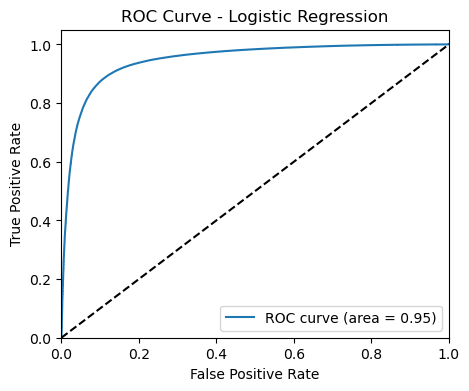

In [134]:
cv_lr_FPR = dict()                                                        # FPR: False Positive Rate
cv_lr_tpr = dict()                                                        # TPR: True Positive Rate
cv_lr_roc_auc = dict()
 
cv_lr_y_test = [i[1] for i in PredAndLabels_list]
cv_lr_y_score = [i[0] for i in PredAndLabels_list]
 
cv_lr_fpr, cv_lr_tpr, _ = roc_curve(cv_lr_y_test, cv_lr_y_score)
cv_lr_roc_auc = auc(cv_lr_fpr, cv_lr_tpr)
 
plt.figure(figsize=(5,4))
plt.plot(cv_lr_fpr, cv_lr_tpr, label='ROC curve (area = %0.2f)' % cv_lr_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('LR_ROC.png')
plt.show()


**Confusion Matrix**

In [63]:
#confusion Matrix
cv_lr_result = cv_lr_prediction.crosstab("prediction", "lose_money")
cv_lr_result = cv_lr_result.toPandas()
cv_lr_result

,prediction_lose_money,0,1
0,1.0,67,7
1,0.0,759323,115041


**Other Metrics**

In [64]:
#calculate Accuracy, Sensitivity, Specificity, Precision
TP = cv_lr_result["1"][0]
FP = cv_lr_result["0"][0]
TN = cv_lr_result["0"][1]
FN = cv_lr_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.87
Sensitivity = 0.00
Specificity = 1.00
Precision = 0.09


While this particular model was technically optimized in terms of AUC, it's not a particularly helpful one for us with a sensistivity of .25. This means that we're only identify 1/4 bad loans, which was our intitial goal. 

## Model 2: Random Forest Classifier

**Build Pipeline for Random Forest Classifier**

In [50]:
from pyspark.mllib.tree import RandomForest
from pyspark.ml.classification import RandomForestClassifier

In [51]:
df = df.drop('emp_length')

In [61]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'lose_money')
rf_pipeline = Pipeline(stages=[stringIndexer_purpose,\
                            stringIndexer_term,\
                            stringIndexer_sub_grade,\
                            stringIndexer_home_ownership,\
                            stringIndexer_verification_status,\
                            encoder_purpose,\
                            encoder_term,\
                            encoder_sub,\
                            encoder_home,\
                            encoder_verif,\
                            va, scalar, rf]) 

In [62]:
rf_model = rf_pipeline.fit(training)

In [63]:
rf_predictions = rf_model.transform(test)

In [64]:
rf_predictions.select("lose_money", "prediction").show(10)

+----------+----------+
|lose_money|prediction|
+----------+----------+
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
+----------+----------+
only showing top 10 rows



**Plotting ROC curve**

In [65]:
PredAndLabels           = rf_predictions.select("probability", "lose_money")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)



In [66]:
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

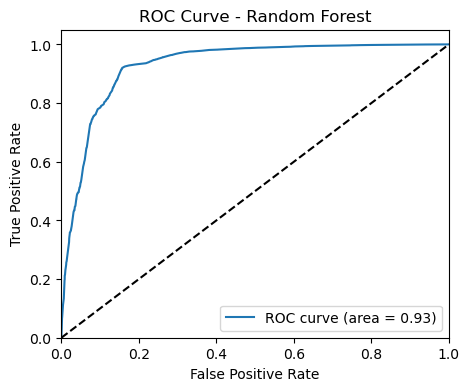

In [67]:
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

**Confusion Matrix**

In [68]:
#confusion Matrix
cm_rf_result = rf_predictions.crosstab("prediction", "lose_money")
cm_rf_result = cm_rf_result.toPandas()
cm_rf_result

,prediction_lose_money,0,1
0,1.0,12,833
1,0.0,759378,114215


In [69]:
#calculate Accuracy, Sensitivity, Specificity, Precision
TP = cm_rf_result["1"][0]
FP = cm_rf_result["0"][0]
TN = cm_rf_result["0"][1]
FN = cm_rf_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.87
Sensitivity = 0.01
Specificity = 1.00
Precision = 0.99


In [70]:
evaluator = BinaryClassificationEvaluator(labelCol='lose_money')

In [71]:
auroc = evaluator.evaluate(rf_predictions)
print('AUROC = ', auroc)

AUROC =  0.9294292992127503


### **Random Forest Classifier Hyperparameter Tuning**

In [72]:
from pyspark.ml.tuning import ParamGridBuilder

import numpy as np

In [73]:
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 5, stop = 15, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 15, num = 3)]) \
    .build()

In [74]:
crossval = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='lose_money'),
                          numFolds=3)
cvModel = crossval.setParallelism(4).fit(training)
prediction = cvModel.transform(test)
prediction.select('lose_money', 'probability', 'prediction').show(10, False)
ModelParamsAndResults1 = zip(cvModel.avgMetrics, rf_paramGrid)
print('Results for Models:')
for model in ModelParamsAndResults1:
    print(model)
    print('-------')
print('-----------------')
print('Results With Best Model:')
trainingSummary = cvModel.bestModel.stages[-1].summary
#trainingSummary.roc.show()
print(f'Area Under ROC: {trainingSummary.areaUnderROC}')

+----------+-----------------------------------------+----------+
|lose_money|probability                              |prediction|
+----------+-----------------------------------------+----------+
|0         |[0.47341945499084453,0.5265805450091555] |1.0       |
|0         |[0.9367871825341142,0.06321281746588583] |0.0       |
|0         |[0.4582615162107544,0.5417384837892456]  |1.0       |
|0         |[0.9526558594582929,0.04734414054170706] |0.0       |
|0         |[0.9483720029773635,0.05162799702263656] |0.0       |
|0         |[0.9794559022813488,0.020544097718651143]|0.0       |
|0         |[0.9775738684566085,0.022426131543391545]|0.0       |
|0         |[0.9446252105505056,0.05537478944949438] |0.0       |
|0         |[0.9823033518139235,0.01769664818607649] |0.0       |
|0         |[0.9858688210222665,0.01413117897773354] |0.0       |
+----------+-----------------------------------------+----------+
only showing top 10 rows

Results for Models:
(0.9014306053362084, {Param(pa

In [75]:
bestModel = cvModel.bestModel

In [76]:
cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]

{Param(parent='RandomForestClassifier_f8e0ceb24862', name='numTrees', doc='Number of trees to train (>= 1).'): 15,
 Param(parent='RandomForestClassifier_f8e0ceb24862', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15}

**Best Model Hyperparameter: number of trees is 10, max depth is 15**



In [77]:
cvModel.bestModel.stages[-1].summary.areaUnderROC

0.9670472201737645

**Plotting ROC Curve**

In [78]:
rf_predictions = bestModel.transform(testData)

In [80]:
PredAndLabels           = rf_predictions.select("probability", "lose_money")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)



In [81]:
cvrf_FPR = dict()                                                        # FPR: False Positive Rate
cvrf_tpr = dict()                                                        # TPR: True Positive Rate
cvrf_roc_auc = dict()
 
cvrf_y_test = [i[1] for i in PredAndLabels_list]
cvrf_y_score = [i[0] for i in PredAndLabels_list]
 
cvrf_fpr, cvrf_tpr, _ = roc_curve(cvrf_y_test, cvrf_y_score)
cvrf_roc_auc = auc(cvrf_fpr, cvrf_tpr)

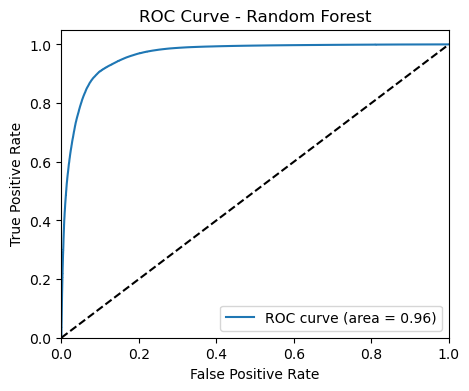

In [82]:
plt.figure(figsize=(5,4))
plt.plot(cvrf_fpr, cvrf_tpr, label='ROC curve (area = %0.2f)' % cvrf_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

**confusion matrix**

In [83]:
cv_rf_result = rf_predictions.crosstab("prediction", "lose_money")
cv_rf_result = cv_rf_result.toPandas()
cv_rf_result

,prediction_lose_money,0,1
0,1.0,8978,80472
1,0.0,750412,34576


**other metrics**

In [84]:
#calculate Accuracy, Sensitivity, Specificity, Precision
TP = cv_rf_result["1"][0]
FP = cv_rf_result["0"][0]
TN = cv_rf_result["0"][1]
FN = cv_rf_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.95
Sensitivity = 0.70
Specificity = 0.99
Precision = 0.90


This model does a much better job than our Logistic Regression especially at identifiying risky loans to avoid (.7 sensitivity)

#### **Feature Importance**

In [85]:
feature_list = ["purpose_ohe","term_ohe",\
                               "sub_grade_ohe", \
                               "home_ohe","verif_ohe",
                                "loan_amnt","DTI","last_fico_range_high", \
                  "total_pymnt","funded_amnt","funded_amnt_inv", \
                   "ANNUAL_INC","revol_bal"]

In [86]:
bestPipeline = cvModel.bestModel.stages[-1]
importances = bestPipeline.featureImportances
importances

SparseVector(63, {0: 0.0005, 1: 0.0004, 2: 0.0003, 3: 0.0003, 4: 0.0002, 5: 0.0002, 6: 0.0002, 7: 0.0001, 8: 0.0001, 9: 0.0001, 10: 0.0001, 11: 0.0001, 12: 0.0, 13: 0.0112, 14: 0.0002, 15: 0.0006, 16: 0.0002, 17: 0.0006, 18: 0.0005, 19: 0.0001, 20: 0.0001, 21: 0.0002, 22: 0.002, 23: 0.0013, 24: 0.0003, 25: 0.0004, 26: 0.0057, 27: 0.0003, 28: 0.0021, 29: 0.0017, 30: 0.0005, 31: 0.0003, 32: 0.0012, 33: 0.001, 34: 0.0021, 35: 0.0025, 36: 0.0025, 37: 0.0009, 38: 0.0012, 39: 0.0013, 40: 0.0007, 41: 0.0004, 42: 0.0003, 43: 0.0002, 44: 0.0002, 45: 0.0001, 46: 0.0001, 47: 0.0001, 48: 0.0009, 49: 0.001, 50: 0.0003, 51: 0.0, 52: 0.0, 53: 0.0028, 54: 0.0106, 55: 0.0202, 56: 0.0043, 57: 0.717, 58: 0.1292, 59: 0.0338, 60: 0.0246, 61: 0.0057, 62: 0.0039})

We see that FICO score is by far the most important feature (.717)

# Model 3: SVM

In [46]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lsvc = LinearSVC(labelCol='lose_money', featuresCol='features', maxIter=10, regParam=0.1)

In [47]:
# Fit the pipeline
lsvc_pipeline = Pipeline(stages=[stringIndexer_purpose,\
                            stringIndexer_term,\
                            stringIndexer_sub_grade,\
                            stringIndexer_home_ownership,\
                            stringIndexer_verification_status,\
                            encoder_purpose,\
                            encoder_term,\
                            encoder_sub,\
                            encoder_home,\
                            encoder_verif,\
                            va, scalar, lsvc]) 

In [52]:
lsvc_model = lsvc_pipeline.fit(training)

In [55]:
training.select("lose_money").show(10)

+----------+
|lose_money|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 10 rows



In [56]:
lsvc_predictions = lsvc_model.transform(test)

In [57]:
lsvc_predictions

DataFrame[lose_money: int, loan_amnt: float, DTI: float, last_fico_range_high: float, total_pymnt: float, funded_amnt: float, funded_amnt_inv: float, ANNUAL_INC: float, revol_bal: float, purpose: string, term: string, sub_grade: string, emp_length: string, home_ownership: string, verification_status: string, purpose_index: double, term_index: double, sub_grade_index: double, home_ownership_index: double, verification_status_index: double, purpose_ohe: vector, term_ohe: vector, sub_grade_ohe: vector, home_ohe: vector, verif_ohe: vector, feature_vector: vector, features: vector, rawPrediction: vector, prediction: double]

In [58]:
preds = lsvc_predictions.select("lose_money", 'rawPrediction', "prediction").show(10, False)

+----------+----------------------------------------+----------+
|lose_money|rawPrediction                           |prediction|
+----------+----------------------------------------+----------+
|0         |[0.8848821930866976,-0.8848821930866976]|0.0       |
|0         |[1.064436813476195,-1.064436813476195]  |0.0       |
|0         |[0.8498125861502541,-0.8498125861502541]|0.0       |
|0         |[1.1298021456529592,-1.1298021456529592]|0.0       |
|0         |[1.1942474946394792,-1.1942474946394792]|0.0       |
|0         |[1.243233149392308,-1.243233149392308]  |0.0       |
|0         |[1.2105109990086393,-1.2105109990086393]|0.0       |
|0         |[1.1577676245946242,-1.1577676245946242]|0.0       |
|0         |[1.176194118683398,-1.176194118683398]  |0.0       |
|0         |[1.2783186905114332,-1.2783186905114332]|0.0       |
+----------+----------------------------------------+----------+
only showing top 10 rows



In [59]:
evaluator = BinaryClassificationEvaluator(labelCol='lose_money')

In [60]:
auc_1 = evaluator.evaluate(lsvc_predictions)
print('Test AUC = ', auc_1)
 

Test AUC =  0.9504524635491514


In [61]:
from pyspark.ml.tuning import ParamGridBuilder

import numpy as np

### **SVM Hyperparameter tuning**

In [65]:
#Define fucntion for fitting paramgrids and evalutaing results
def lsvc_fitModelsGetResults(paramGrid):
    crossval = CrossValidator(estimator=lsvc_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='lose_money'),
                          numFolds=3)
    cvModel = crossval.setParallelism(2).fit(training)
    prediction = cvModel.transform(test)
    prediction.select('lose_money', 'prediction').show(10, False)
    ModelParamsAndResults1 = zip(cvModel.avgMetrics, paramGrid)
    print('Results for Models:')
    for model in ModelParamsAndResults1:
        print(model)
        print('-------')
    print('-----------------')
    print('Results With Best Model:')
    

    evaluator0 = BinaryClassificationEvaluator(
        labelCol='lose_money')
    AUC = evaluator0.evaluate(prediction)
    print(f'Area Under ROC: {AUC}')
    evaluator = MulticlassClassificationEvaluator(
        labelCol='lose_money', 
        predictionCol='prediction', 
        metricName='accuracy')
    accuracy = evaluator.evaluate(prediction)
    print(f'Test Accuracy = {accuracy}')
    evaluator2 = MulticlassClassificationEvaluator(
        labelCol='lose_money', 
        predictionCol='prediction', 
        metricName='precisionByLabel')
    precision = evaluator2.evaluate(prediction)
    print(f'Precision = {precision}')
    evaluator3 = MulticlassClassificationEvaluator(
        labelCol='lose_money', 
        predictionCol='prediction', 
        metricName='recallByLabel')
    recall = evaluator3.evaluate(prediction)
    print(f'Recall = {recall}')

In [66]:
#test
lsvc_paramGrid_test = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [5]) \
    .addGrid(lsvc.regParam, [.1]) \
    .build()

In [67]:
lsvc_fitModelsGetResults(lsvc_paramGrid_test)

+----------+----------+
|lose_money|prediction|
+----------+----------+
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
+----------+----------+
only showing top 10 rows

Results for Models:
(0.9440268546904731, {Param(parent='LinearSVC_fd2718c12eee', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='LinearSVC_fd2718c12eee', name='regParam', doc='regularization parameter (>= 0).'): 0.1})
-------
-----------------
Results With Best Model:
Area Under ROC: 0.9433523348680934
Test Accuracy = 0.8684320672248919
Precision = 0.8684320672248919
Recall = 1.0


#### ParamGrids

In [68]:
lsvc_paramGrid_1 = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [5]) \
    .addGrid(lsvc.regParam, [0.2, 0.1]) \
    .build()

In [69]:
lsvc_paramGrid_2 = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [5]) \
    .addGrid(lsvc.regParam, [0.01, 0]) \
    .build()

In [70]:
lsvc_paramGrid_3 = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [10]) \
    .addGrid(lsvc.regParam, [0.2, 0.1]) \
    .build()

In [71]:
lsvc_paramGrid_4 = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [10]) \
    .addGrid(lsvc.regParam, [0.01, 0]) \
    .build()

In [72]:
lsvc_paramGrid_5 = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [15]) \
    .addGrid(lsvc.regParam, [0.2, 0.1]) \
    .build()

In [73]:
lsvc_paramGrid_6 = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [15]) \
    .addGrid(lsvc.regParam, [0.01, 0]) \
    .build()

In [74]:
%%time
lsvc_fitModelsGetResults(lsvc_paramGrid_1)

+----------+----------+
|lose_money|prediction|
+----------+----------+
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
+----------+----------+
only showing top 10 rows

Results for Models:
(0.9439764624044067, {Param(parent='LinearSVC_fd2718c12eee', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='LinearSVC_fd2718c12eee', name='regParam', doc='regularization parameter (>= 0).'): 0.2})
-------
(0.9440277345799202, {Param(parent='LinearSVC_fd2718c12eee', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='LinearSVC_fd2718c12eee', name='regParam', doc='regularization parameter (>= 0).'): 0.1})
-------
-----------------
Results With Best Model:
Area Under ROC: 0.9433518003484948
Test Accuracy = 0.8684320672248919
Precision = 0.8684320672248919
Recall = 1

In [75]:
%%time
lsvc_fitModelsGetResults(lsvc_paramGrid_2)

+----------+----------+
|lose_money|prediction|
+----------+----------+
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
+----------+----------+
only showing top 10 rows

Results for Models:
(0.9442452752717273, {Param(parent='LinearSVC_fd2718c12eee', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='LinearSVC_fd2718c12eee', name='regParam', doc='regularization parameter (>= 0).'): 0.01})
-------
(0.9439718205166485, {Param(parent='LinearSVC_fd2718c12eee', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='LinearSVC_fd2718c12eee', name='regParam', doc='regularization parameter (>= 0).'): 0.0})
-------
-----------------
Results With Best Model:
Area Under ROC: 0.9429271601474761
Test Accuracy = 0.8684320672248919
Precision = 0.8684320672248919
Recall = 

In [76]:
%%time
lsvc_fitModelsGetResults(lsvc_paramGrid_3)

+----------+----------+
|lose_money|prediction|
+----------+----------+
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
+----------+----------+
only showing top 10 rows

Results for Models:
(0.9504681958550159, {Param(parent='LinearSVC_fd2718c12eee', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LinearSVC_fd2718c12eee', name='regParam', doc='regularization parameter (>= 0).'): 0.2})
-------
(0.9501903576867754, {Param(parent='LinearSVC_fd2718c12eee', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LinearSVC_fd2718c12eee', name='regParam', doc='regularization parameter (>= 0).'): 0.1})
-------
-----------------
Results With Best Model:
Area Under ROC: 0.9499061684948036
Test Accuracy = 0.8684309236332365
Precision = 0.8684319167647297
Recall =

In [77]:
%%time
lsvc_fitModelsGetResults(lsvc_paramGrid_4)

+----------+----------+
|lose_money|prediction|
+----------+----------+
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
+----------+----------+
only showing top 10 rows

Results for Models:
(0.9487914924300187, {Param(parent='LinearSVC_fd2718c12eee', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LinearSVC_fd2718c12eee', name='regParam', doc='regularization parameter (>= 0).'): 0.01})
-------
(0.947963403564948, {Param(parent='LinearSVC_fd2718c12eee', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LinearSVC_fd2718c12eee', name='regParam', doc='regularization parameter (>= 0).'): 0.0})
-------
-----------------
Results With Best Model:
Area Under ROC: 0.9451617566954712
Test Accuracy = 0.8684309236332365
Precision = 0.8684319167647297
Recall =

In [78]:
%%time
lsvc_fitModelsGetResults(lsvc_paramGrid_5)

+----------+----------+
|lose_money|prediction|
+----------+----------+
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
+----------+----------+
only showing top 10 rows

Results for Models:
(0.9536186211066531, {Param(parent='LinearSVC_fd2718c12eee', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='LinearSVC_fd2718c12eee', name='regParam', doc='regularization parameter (>= 0).'): 0.2})
-------
(0.9528456066759554, {Param(parent='LinearSVC_fd2718c12eee', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='LinearSVC_fd2718c12eee', name='regParam', doc='regularization parameter (>= 0).'): 0.1})
-------
-----------------
Results With Best Model:
Area Under ROC: 0.952390225564995
Test Accuracy = 0.8684320672248919
Precision = 0.868433752575952
Recall = 0

In [79]:
%%time
lsvc_fitModelsGetResults(lsvc_paramGrid_6)

+----------+----------+
|lose_money|prediction|
+----------+----------+
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
|0         |0.0       |
+----------+----------+
only showing top 10 rows

Results for Models:
(0.9518201429168924, {Param(parent='LinearSVC_fd2718c12eee', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='LinearSVC_fd2718c12eee', name='regParam', doc='regularization parameter (>= 0).'): 0.01})
-------
(0.9515654160585378, {Param(parent='LinearSVC_fd2718c12eee', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='LinearSVC_fd2718c12eee', name='regParam', doc='regularization parameter (>= 0).'): 0.0})
-------
-----------------
Results With Best Model:
Area Under ROC: 0.9511999361840442
Test Accuracy = 0.8684309236332365
Precision = 0.868433602117029
Recall =

### Results with best Hyperparameters
Best Model Hyperparameters = 15 iterations & regParam = .2 (.9541 Test AUC)

In [135]:
lsvc_paramGrid_best = ParamGridBuilder() \
    .addGrid(lsvc.maxIter, [15]) \
    .addGrid(lsvc.regParam, [0.2]) \
    .build()

In [136]:
crossval = CrossValidator(estimator=lsvc_pipeline,
                          estimatorParamMaps=lsvc_paramGrid_best,
                          evaluator=BinaryClassificationEvaluator(labelCol='lose_money'),
                          numFolds=3)
cvModel = crossval.fit(training)
lsvc_predictions = cvModel.transform(test)

In [137]:
#confusion Matrix
cm_lsvc_result = lsvc_predictions.crosstab("prediction", "lose_money")
cm_lsvc_result = cm_lsvc_result.toPandas()
cm_lsvc_result

,prediction_lose_money,0,1
0,1.0,2,2
1,0.0,759388,115046


In [138]:
#calculate Accuracy, Sensitivity, Specificity, Precision
TP = cm_lsvc_result["1"][0]
FP = cm_lsvc_result["0"][0]
TN = cm_lsvc_result["0"][1]
FN = cm_lsvc_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.87
Sensitivity = 0.00
Specificity = 1.00
Precision = 0.50


In [ ]:
This model performed very similarly to our logistic regression model

## Model 4: GBT

In [80]:
from pyspark.mllib.tree import RandomForest
from pyspark.ml.classification import GBTClassifier

In [84]:
gbt = GBTClassifier(labelCol = 'lose_money', featuresCol = 'features')

In [85]:
gbt_pipeline = Pipeline(stages=[stringIndexer_purpose,\
                            stringIndexer_term,\
                            stringIndexer_sub_grade,\
                            stringIndexer_home_ownership,\
                            stringIndexer_verification_status,\
                            encoder_purpose,\
                            encoder_term,\
                            encoder_sub,\
                            encoder_home,\
                            encoder_verif,\
                            va, scalar, gbt]) 

In [86]:
gbt_model =gbt_pipeline.fit(training)

In [87]:
gbt_predictions = gbt_model.transform(test)

In [88]:
gbt_predictions.select("lose_money", "prediction").show(10)

+----------+----------+
|lose_money|prediction|
+----------+----------+
|         0|       1.0|
|         0|       0.0|
|         0|       1.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
+----------+----------+
only showing top 10 rows



**Plotting ROC curve**

In [89]:
PredAndLabels           = gbt_predictions.select("probability", "lose_money")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)



In [90]:
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

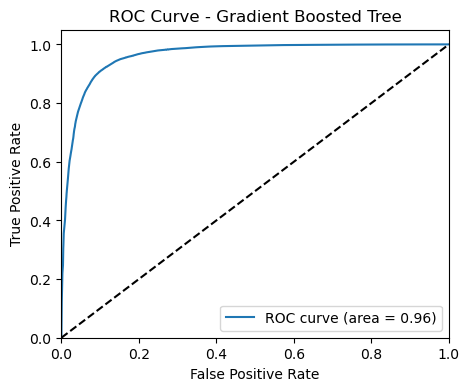

In [119]:
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosted Tree')
plt.legend(loc="lower right")
plt.savefig('GBT_ROC_1')
plt.show()

**Confusion Matrix**

In [92]:
#confusion Matrix
cm_gbt_result = gbt_predictions.crosstab("prediction", "lose_money")
cm_gbt_result = cm_gbt_result.toPandas()
cm_gbt_result

,prediction_lose_money,0,1
0,1.0,12627,82909
1,0.0,746763,32139


In [93]:
#calculate Accuracy, Sensitivity, Specificity, Precision
TP = cm_gbt_result["1"][0]
FP = cm_gbt_result["0"][0]
TN = cm_gbt_result["0"][1]
FN = cm_gbt_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.95
Sensitivity = 0.72
Specificity = 0.98
Precision = 0.87


In [94]:
evaluator = BinaryClassificationEvaluator(labelCol='lose_money')

In [95]:
auroc = evaluator.evaluate(gbt_predictions)
print('AUROC = ', auroc)

AUROC =  0.9626660972867159


### **GBT Hyperparameter Tuning**

In [72]:
from pyspark.ml.tuning import ParamGridBuilder

import numpy as np

In [96]:
gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [int(x) for x in np.linspace(start = 5, stop = 15, num = 3)]) \
    .addGrid(gbt.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 15, num = 3)]) \
    .build()

In [98]:
crossval = CrossValidator(estimator=gbt_pipeline,
                          estimatorParamMaps=gbt_paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='lose_money'),
                          numFolds=3)
cvModel = crossval.setParallelism(4).fit(training)
prediction = cvModel.transform(test)
prediction.select('lose_money', 'probability', 'prediction').show(10, False)

In [105]:
ModelParamsAndResults1 = zip(cvModel.avgMetrics, gbt_paramGrid)
print('Results for Models:')
for model in ModelParamsAndResults1:
    print(model)
    print('-------')
print('-----------------')
print('Results With Best Model:')

Results for Models:
(0.9587158326417946, {Param(parent='GBTClassifier_c828bb96e40e', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='GBTClassifier_c828bb96e40e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5})
-------
(0.9712013748644843, {Param(parent='GBTClassifier_c828bb96e40e', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='GBTClassifier_c828bb96e40e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10})
-------
(0.9644923401941945, {Param(parent='GBTClassifier_c828bb96e40e', name='maxIter', doc='max number of iterations (>= 0).'): 5, Param(parent='GBTClassifier_c828bb96e40e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15})
-------
(0.9615471129009616, {Pa

In [100]:
bestModel = cvModel.bestModel

In [101]:
#Best Model Hyperparameters
cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]

{Param(parent='GBTClassifier_c828bb96e40e', name='maxIter', doc='max number of iterations (>= 0).'): 15,
 Param(parent='GBTClassifier_c828bb96e40e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10}

**Best Model Hyperparameter: max iterations is 15, max depth is 10**



**Plotting ROC Curve**

In [103]:
gbt_predictions = bestModel.transform(test)

In [104]:
PredAndLabels           = gbt_predictions.select("probability", "lose_money")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)



In [106]:
cvgbt_FPR = dict()                                                        # FPR: False Positive Rate
cvgbt_tpr = dict()                                                        # TPR: True Positive Rate
cvgbt_roc_auc = dict()
 
cvgbt_y_test = [i[1] for i in PredAndLabels_list]
cvgbt_y_score = [i[0] for i in PredAndLabels_list]
 
cvgbt_fpr, cvgbt_tpr, _ = roc_curve(cvgbt_y_test, cvgbt_y_score)
cvgbt_roc_auc = auc(cvgbt_fpr, cvgbt_tpr)

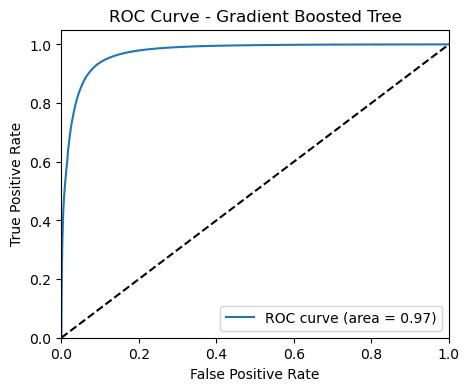

In [120]:
plt.figure(figsize=(5,4))
plt.plot(cvgbt_fpr, cvgbt_tpr, label='ROC curve (area = %0.2f)' % cvgbt_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosted Tree')
plt.legend(loc="lower right")
plt.savefig('GBT_ROC_2.png')
plt.show()

**confusion matrix**

In [108]:
cv_gbt_result = gbt_predictions.crosstab("prediction", "lose_money")
cv_gbt_result = cv_gbt_result.toPandas()
cv_gbt_result

,prediction_lose_money,0,1
0,1.0,13405,89934
1,0.0,745985,25114


**other metrics**

In [109]:
#calculate Accuracy, Sensitivity, Specificity, Precision
TP = cv_gbt_result["1"][0]
FP = cv_gbt_result["0"][0]
TN = cv_gbt_result["0"][1]
FN = cv_gbt_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.96
Sensitivity = 0.78
Specificity = 0.98
Precision = 0.87


This was our best performing models, not only in terms of AUC (.95), but also in terms of sensitivity (.78). Again, sensitivity shows how well we are dientifying loans that went on to lose money, so we are particularly interested in maximizing that. 

#### **Feature Importance**

In [110]:
feature_list = ["purpose_ohe","term_ohe",\
                               "sub_grade_ohe", \
                               "home_ohe","verif_ohe",
                                "loan_amnt","DTI","last_fico_range_high", \
                  "total_pymnt","funded_amnt","funded_amnt_inv", \
                   "ANNUAL_INC","revol_bal"]

In [111]:
bestPipeline = cvModel.bestModel.stages[-1]
importances = bestPipeline.featureImportances
importances

SparseVector(63, {0: 0.0015, 1: 0.0022, 2: 0.0005, 3: 0.0006, 4: 0.0003, 5: 0.0003, 6: 0.0009, 7: 0.0002, 8: 0.0002, 9: 0.0006, 10: 0.0003, 11: 0.0006, 12: 0.0001, 13: 0.0084, 14: 0.0002, 15: 0.0002, 16: 0.0003, 17: 0.0004, 18: 0.0004, 19: 0.0003, 20: 0.0004, 21: 0.0002, 22: 0.0006, 23: 0.0005, 24: 0.0001, 25: 0.0014, 26: 0.0006, 27: 0.0023, 28: 0.0003, 29: 0.0004, 30: 0.0003, 31: 0.0012, 32: 0.0006, 33: 0.0006, 34: 0.0039, 35: 0.0031, 36: 0.0033, 37: 0.0023, 38: 0.0033, 39: 0.0025, 40: 0.0028, 41: 0.0021, 42: 0.0015, 43: 0.0015, 44: 0.0012, 45: 0.001, 46: 0.0005, 47: 0.0005, 48: 0.0008, 49: 0.0009, 50: 0.0005, 51: 0.0004, 53: 0.0044, 54: 0.0064, 55: 0.0425, 56: 0.0147, 57: 0.6314, 58: 0.1381, 59: 0.0517, 60: 0.0246, 61: 0.0183, 62: 0.0079})

Again, FICO is clearly most important (.6314)